<a href="https://colab.research.google.com/github/DmitriySudd/DmitriySudd/blob/main/OpenCV_%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BB%D0%B8%D1%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Эксперимент:
1. Найти фото любого известного актера или актрисы.
2. Распознать лицо на фотографии. Выделить лицо овалом.
3. Выделить на изображении глаза. Выделите их кружком. Нарисовать вместо кружков солнцезащитные очки.
4. Все лицо кроме глаз необходимо "заблюрить" (размыть).

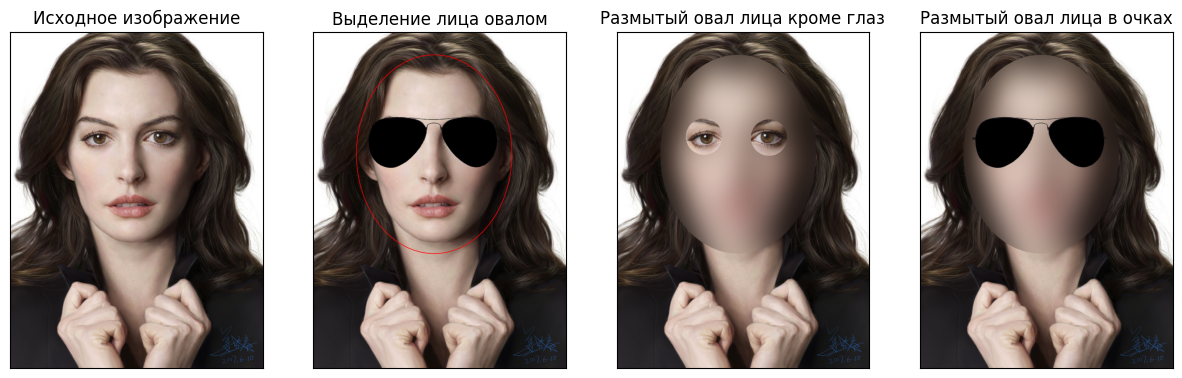

In [ ]:
import cv2
import gdown
import numpy as np
from matplotlib import pyplot as plt

# Считываем фотографию актрисы
img = cv2.imread('anne-hathaway.jpg')
# Считываем изображение солнечных очков
glasses_mask = cv2.imread('sunglass1.png')
h_mask, w_mask = glasses_mask.shape[:2]


def blur_face(img):
    (h, w) = img.shape[:2]
    dW = int(w / 3.0)
    dH = int(h / 3.0)
    if dW % 2 == 0:
        dW -= 1
    if dH % 2 == 0:
        dH -= 1
    return cv2.GaussianBlur(img, (dW, dH), 0)


# Копируем исходное изображение
img2 = img.copy()
img3 = img.copy()
# Загружаем необходимые каскады
classifier = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")
classifier_smile = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_smile.xml")
ellipses = classifier.detectMultiScale(img)
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

# формирование координат
x, y, width, height = ellipses[0]
x2, y2 = x + width, y + height
center = (int(x + 0.5 * width), int(y + 0.5 * height))
axesLength = int(x * 1.8), int(y * 2.2)  # размер элипса
face = img2[y-150:y + height, x-60:x + width]  # найденная область с лицом
face2 = img3[y-150:y + height, x-60:x + width]
color = (0, 0, 255)

# рисование овала
cv2.ellipse(img2, center, axesLength, 0, 0, 360, (0, 0, 255), 4)

gl_eyes = classifier_eye.detectMultiScale(face, scaleFactor=1.2, minNeighbors=40, minSize=(20, 20))
eyes = classifier_eye.detectMultiScale(face, scaleFactor=1.2, minNeighbors=40, minSize=(20, 20))
# выполнение распознавания улыбок
smiles = classifier_smile.detectMultiScale(face, scaleFactor=1.30, minNeighbors=65, minSize=(20, 20))

for (sx, sy, sw, sh) in smiles:
    # print((sx, sy, sw, sh))
    # отрисовка прямоугольника около улыбки
    cv2.rectangle(face2, (sx, sy - 50), ((sx + sw), (sy + sh)), (255, 0, 0), 2)

# подгонка размеров солнечных очков
(mx, my, mw, mh) = gl_eyes[0]
mx = mx - mx // 2
my = my - 50
mw = int(mw * 4)
mh = int(mh * 1.6)
eye = face[my:my + mh, mx:mx + mw]

glasses_mask_small = cv2.resize(glasses_mask, (mw, mh), interpolation=cv2.INTER_AREA)
gray_mask = cv2.cvtColor(glasses_mask_small, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(gray_mask, 50, 255, cv2.THRESH_BINARY_INV)
mask_inv = cv2.bitwise_not(mask)
masked_eye = cv2.bitwise_and(glasses_mask_small, glasses_mask_small, mask=mask)

masked_face = cv2.bitwise_and(eye, eye, mask=mask_inv)
face[my:my + mh, mx:mx + mw] = cv2.add(masked_eye, masked_face)

center_eyes = []
for (x_eye, y_eye, w_eye, h_eye) in eyes:
    # определяем центр круга
    center_e = (int(x_eye + 0.5 * w_eye), int(y_eye + 0.5 * h_eye))
    center_eyes.append((int(x_eye + 1.6 * w_eye), int(y_eye + 1.2 * h_eye)))
    # вычисляем радиус окружности (подобран эмпирическим путем)
    radius = int(0.25 * (w_eye + h_eye))
    color = (0, 255, 0)  # цвет в RGB (интенсивность цветов красный-зеленый-синий от 0 до 255)
    thickness = 3  # толщина линии


mask_img2 = np.zeros(img3.shape, dtype='uint8')
cv2.ellipse(mask_img2, center, axesLength, 0, 0, 360, (255, 255, 255), -1)
cv2.circle(mask_img2, center_eyes[0], radius, (0, 0, 0), -1)
cv2.circle(mask_img2, center_eyes[1], radius, (0, 0, 0), -1)

img_all_blurred = blur_face(img3)
img3 = np.where(mask_img2 > 0, img_all_blurred, img3)

img4 = img3.copy()
face3 = img4[y-150:y + height, x-60:x + width]

eye = face3[my:my + mh, mx:mx + mw]
glasses_mask_small = cv2.resize(glasses_mask, (mw, mh), interpolation=cv2.INTER_AREA)
gray_mask = cv2.cvtColor(glasses_mask_small, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(gray_mask, 50, 255, cv2.THRESH_BINARY_INV)
mask_inv = cv2.bitwise_not(mask)
masked_eye = cv2.bitwise_and(glasses_mask_small, glasses_mask_small, mask=mask)
masked_face = cv2.bitwise_and(eye, eye, mask=mask_inv)
face3[my:my + mh, mx:mx + mw] = cv2.add(masked_eye, masked_face)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Выделение лица овалом')

ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax3.xaxis.set_ticks([])
ax3.yaxis.set_ticks([])
ax3.set_title('Размытый овал лица кроме глаз')

ax4.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax4.xaxis.set_ticks([])
ax4.yaxis.set_ticks([])
ax4.set_title('Размытый овал лица в очках')

plt.show()
